In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, average_precision_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 北欧

## 1.1 预测挪威

In [52]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Sweden','Finland','Denmark','Iceland'])]
test_data = data[data['Market'] == 'Norway']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Sweden     322
 Finland     73
 Denmark     64
 Iceland      8
 Name: count, dtype: int64,
 Market
 Norway    93
 Name: count, dtype: int64)

In [53]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [54]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8244111349036403 F1 Score: 0.8225664778383335 AUC: 0.957017269118051 prAUC: 0.8906540491895063
Test Results: Accuracy: 0.6236559139784946 F1 Score: 0.61269733850379 AUC: 0.8422224361375527 prAUC: 0.6323230358131231


In [55]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9057815845824411 F1 Score: 0.9055454533643635 AUC: 0.9882784299901051 prAUC: 0.9679870624048239
Test Results: Accuracy: 0.6344086021505376 F1 Score: 0.6239593102999034 AUC: 0.8374492213481973 prAUC: 0.6361786879294351


In [68]:
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=2,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=50,                # 降低树的深度
    n_estimators=1500,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Train Results: Accuracy: 0.8693790149892934 F1 Score: 0.8687117504643534 AUC: 0.9782392381387998 prAUC: 0.9451278764419213
Test Results: Accuracy: 0.6559139784946236 F1 Score: 0.6457878665669813 AUC: 0.8395068080749943 prAUC: 0.6203553994250214


In [26]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.8329764453961456 F1 Score: 0.83108353698632 AUC: 0.9643050626922856 prAUC: 0.906087480442472
Test Results: Accuracy: 0.5913978494623656 F1 Score: 0.5801225673424752 AUC: 0.843848564276012 prAUC: 0.636557197756661


In [27]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 500, 'max_depth': 30, 'learning_rate': 0.01, 'lambda': 2, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.8565310492505354 F1 Score: 0.8539683781363353 AUC: 0.9766817960090414 prAUC: 0.9387110460150113
Test Results: Accuracy: 0.5698924731182796 F1 Score: 0.5478736801317446 AUC: 0.8349110997184019 prAUC: 0.6260570837973105


In [28]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8473015537351571, 'gamma': 0, 'learning_rate': 0.3378613176903711, 'max_depth': 14, 'min_child_weight': 2, 'n_estimators': 314, 'reg_alpha': 1, 'reg_lambda': 7, 'subsample': 0.5590824138108281}

Train Results: Accuracy: 1.0 F1 Score: 1.0 AUC: 1.0 prAUC: 1.0
Test Results: Accuracy: 0.5913978494623656 F1 Score: 0.5822863098020882 AUC: 0.8066565885086144 prAUC: 0.6217310433343792


## 1.2 预测瑞典

In [29]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Finland','Denmark','Iceland','Norway'])]
test_data = data[data['Market'] == 'Sweden']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Norway     93
 Finland    73
 Denmark    64
 Iceland     8
 Name: count, dtype: int64,
 Market
 Sweden    322
 Name: count, dtype: int64)

In [30]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [31]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8277310924369747 F1 Score: 0.822712753748619 AUC: 0.9513621346202206 prAUC: 0.8723909810893641
Test Results: Accuracy: 0.6335403726708074 F1 Score: 0.6291900892019789 AUC: 0.8589013484834784 prAUC: 0.6702990043276129


In [49]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=3,               # L1 正则化
    reg_lambda=3,              # L2 正则化
    gamma =0,                   # 添加 gamma 限制分裂
    max_depth=12,                # 降低树的深度
    n_estimators=800,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42,
    colsample_bylevel=0.8
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9938398357289527 F1 Score: 0.9937849842100867 AUC: 0.9999483262010685 prAUC: 0.9997341010691987
Test Results: Accuracy: 0.684931506849315 F1 Score: 0.6454188150976454 AUC: 0.8827151461150626 prAUC: 0.6671547055207837


In [33]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.8445378151260504 F1 Score: 0.8408709487527215 AUC: 0.9596599325203147 prAUC: 0.8902712250840085
Test Results: Accuracy: 0.6366459627329193 F1 Score: 0.633797552675117 AUC: 0.8602429649753287 prAUC: 0.666535702788123


In [34]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 300, 'max_depth': 30, 'learning_rate': 0.1, 'lambda': 2, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.8949579831932774 F1 Score: 0.8923313331111459 AUC: 0.980704232700414 prAUC: 0.9363823229791685
Test Results: Accuracy: 0.639751552795031 F1 Score: 0.6364380411751422 AUC: 0.8653523340185104 prAUC: 0.6833157643107334


In [35]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.7693605922825478, 'gamma': 0, 'learning_rate': 0.1093578407670862, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 792, 'reg_alpha': 3, 'reg_lambda': 3, 'subsample': 0.8856351733429728}

Train Results: Accuracy: 0.9705882352941176 F1 Score: 0.9702261302058913 AUC: 0.9989955039671027 prAUC: 0.9941127247586243
Test Results: Accuracy: 0.6428571428571429 F1 Score: 0.637594140329371 AUC: 0.8615710832677664 prAUC: 0.681682932781538


## 1.3 预测芬兰

In [18]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Sweden','Denmark','Iceland','Norway'])]
test_data = data[data['Market'] == 'Finland']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Sweden     322
 Norway      93
 Denmark     64
 Iceland      8
 Name: count, dtype: int64,
 Market
 Finland    73
 Name: count, dtype: int64)

In [19]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [38]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8193018480492813 F1 Score: 0.8179155888601475 AUC: 0.9535933073690169 prAUC: 0.8870396046764362
Test Results: Accuracy: 0.6164383561643836 F1 Score: 0.5472886262572 AUC: 0.8848138710818114 prAUC: 0.6864369647926007


In [46]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=31,                # 降低树的深度
    n_estimators=400,          # 树的数量
    learning_rate=0.05,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8788501026694046 F1 Score: 0.8775349343401725 AUC: 0.9824161189914611 prAUC: 0.9546619051441809
Test Results: Accuracy: 0.6712328767123288 F1 Score: 0.6225848719475878 AUC: 0.8967297643965315 prAUC: 0.7225375733243586


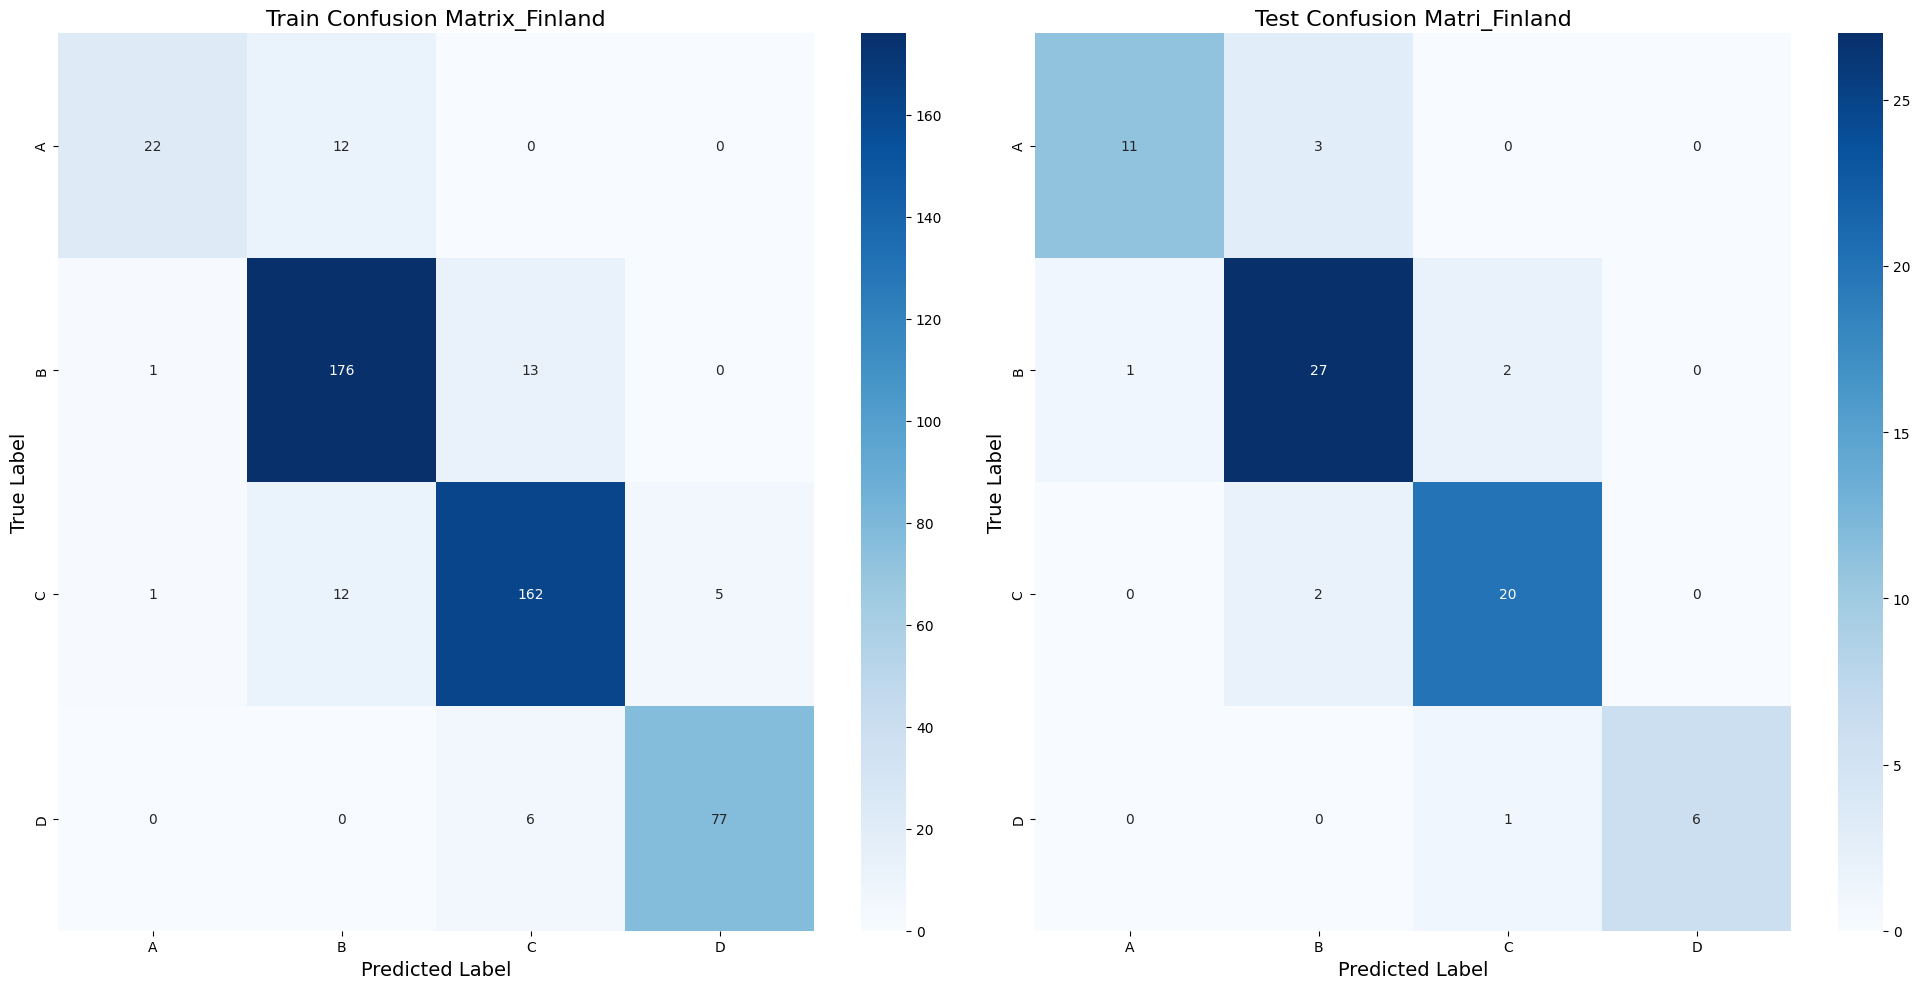

In [22]:
# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# 绘制训练集和测试集的混淆矩阵
y_train_pred = tuned_xgb_model.predict(X_train)
y_test_pred = tuned_xgb_model.predict(X_test)

conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(20, 10))

# 训练集混淆矩阵
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Train Confusion Matrix_Finland', fontsize=16)

# 测试集混淆矩阵
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Test Confusion Matri_Finland', fontsize=16)

plt.tight_layout()
plt.show()


SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (487, 41, 4)


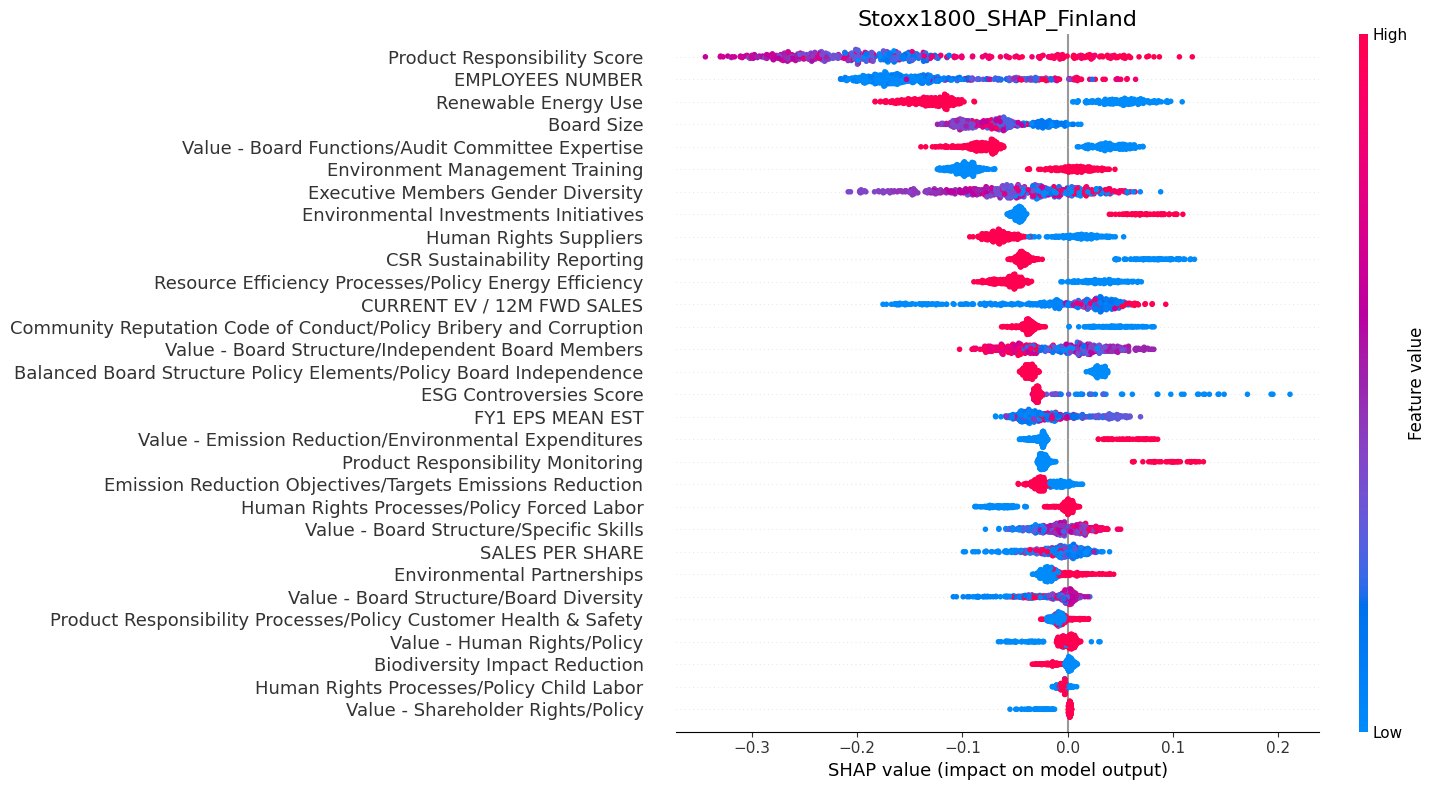

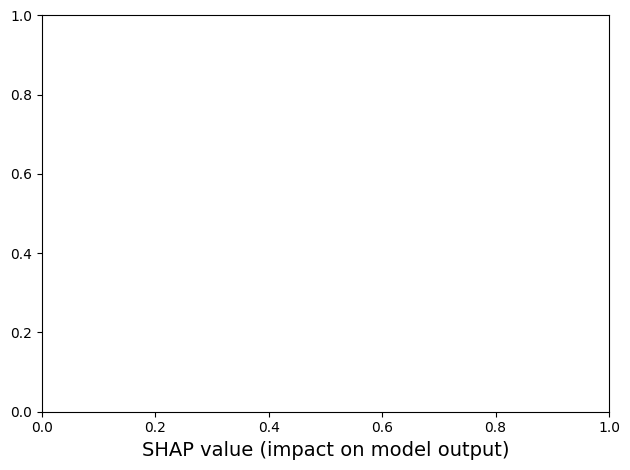

In [23]:
import shap
import matplotlib.pyplot as plt

# 使用 SHAP 解释器计算 SHAP 值
explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)

# 输出 shap_values 的类型和形状
print("SHAP values type:", type(shap_values))
if isinstance(shap_values, list):
    print("SHAP values shape (for each class):", [sv.shape for sv in shap_values])
else:
    print("SHAP values shape:", shap_values.shape)

# 确保 feature_names 被定义
feature_names = X_train.columns

# 绘制总体 SHAP summary plot
# 将 SHAP 值按类别进行平均，得到总体 SHAP 值
shap_values_mean = shap_values.mean(axis=2)

plt.figure(figsize=(15, 8))  # 增大图形尺寸
plt.title("Stoxx1800_SHAP_Finland", fontsize=16)  # 增大标题字体
shap.summary_plot(shap_values_mean, X_train, feature_names=feature_names, max_display=30, plot_size=(15, 8))
plt.xlabel("SHAP value (impact on model output)", fontsize=14)  # 增大x轴标签字体
plt.tight_layout()  # 自动调整布局
plt.show()  # 显示图形

In [40]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 2, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.8172484599589322 F1 Score: 0.8159454164220755 AUC: 0.95709734784201 prAUC: 0.8972887597515903
Test Results: Accuracy: 0.6027397260273972 F1 Score: 0.5354445339779748 AUC: 0.8896323211980891 prAUC: 0.7078013985494953


In [41]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 300, 'max_depth': 30, 'learning_rate': 0.1, 'lambda': 2, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.8767967145790554 F1 Score: 0.8760303999774126 AUC: 0.9829879425221437 prAUC: 0.9574598111990309
Test Results: Accuracy: 0.6575342465753424 F1 Score: 0.6102879507967571 AUC: 0.8919607155579472 prAUC: 0.6650509251860373


In [42]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8447411578889518, 'gamma': 1, 'learning_rate': 0.033332831606807715, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 443, 'reg_alpha': 1, 'reg_lambda': 3, 'subsample': 0.9299702033681603}

Train Results: Accuracy: 0.8542094455852156 F1 Score: 0.8525060817420995 AUC: 0.9760110586005506 prAUC: 0.939251306746334
Test Results: Accuracy: 0.6575342465753424 F1 Score: 0.6171089184787816 AUC: 0.8795270109333733 prAUC: 0.6485179302498255


## 1.4 预测丹麦

In [11]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Sweden','Finland','Iceland','Norway'])]
test_data = data[data['Market'] == 'Denmark']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Sweden     322
 Norway      93
 Finland     73
 Iceland      8
 Name: count, dtype: int64,
 Market
 Denmark    64
 Name: count, dtype: int64)

In [12]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


In [71]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)



Train Results: Accuracy: 0.7923387096774194 F1 Score: 0.7922773846383419 AUC: 0.9519192074230572 prAUC: 0.8874457303588491
Test Results: Accuracy: 0.75 F1 Score: 0.7363095238095239 AUC: 0.8967503744551443 prAUC: 0.7081179930299997


In [ ]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


In [13]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.907258064516129 F1 Score: 0.9066533246015418 AUC: 0.9877583790733382 prAUC: 0.9706914760026073
Test Results: Accuracy: 0.796875 F1 Score: 0.7760416666666667 AUC: 0.8857984475146734 prAUC: 0.6675669580564548


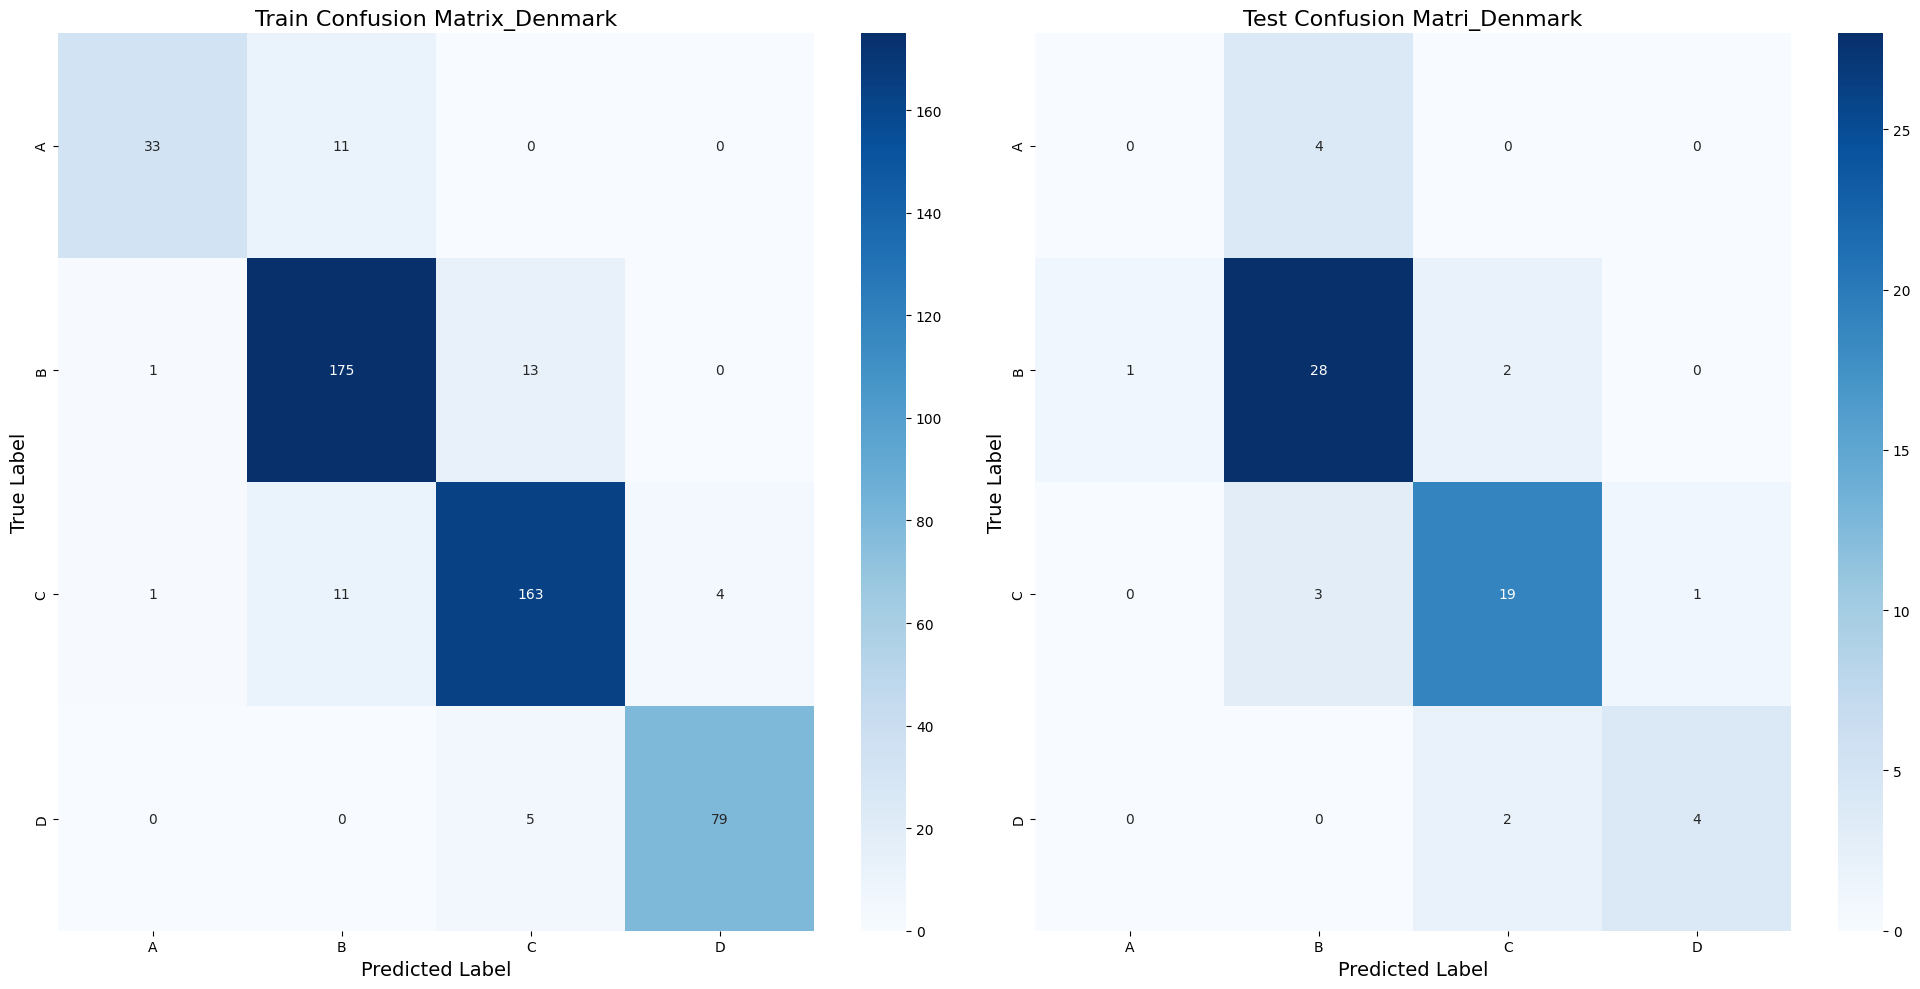

In [16]:
#绘制混淆矩阵
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# 绘制训练集和测试集的混淆矩阵
y_train_pred = tuned_xgb_model.predict(X_train)
y_test_pred = tuned_xgb_model.predict(X_test)

conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(20, 10))

# 训练集混淆矩阵
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Train Confusion Matrix_Denmark', fontsize=16)

# 测试集混淆矩阵
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Test Confusion Matri_Denmark', fontsize=16)

plt.tight_layout()
plt.show()


SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (496, 41, 4)


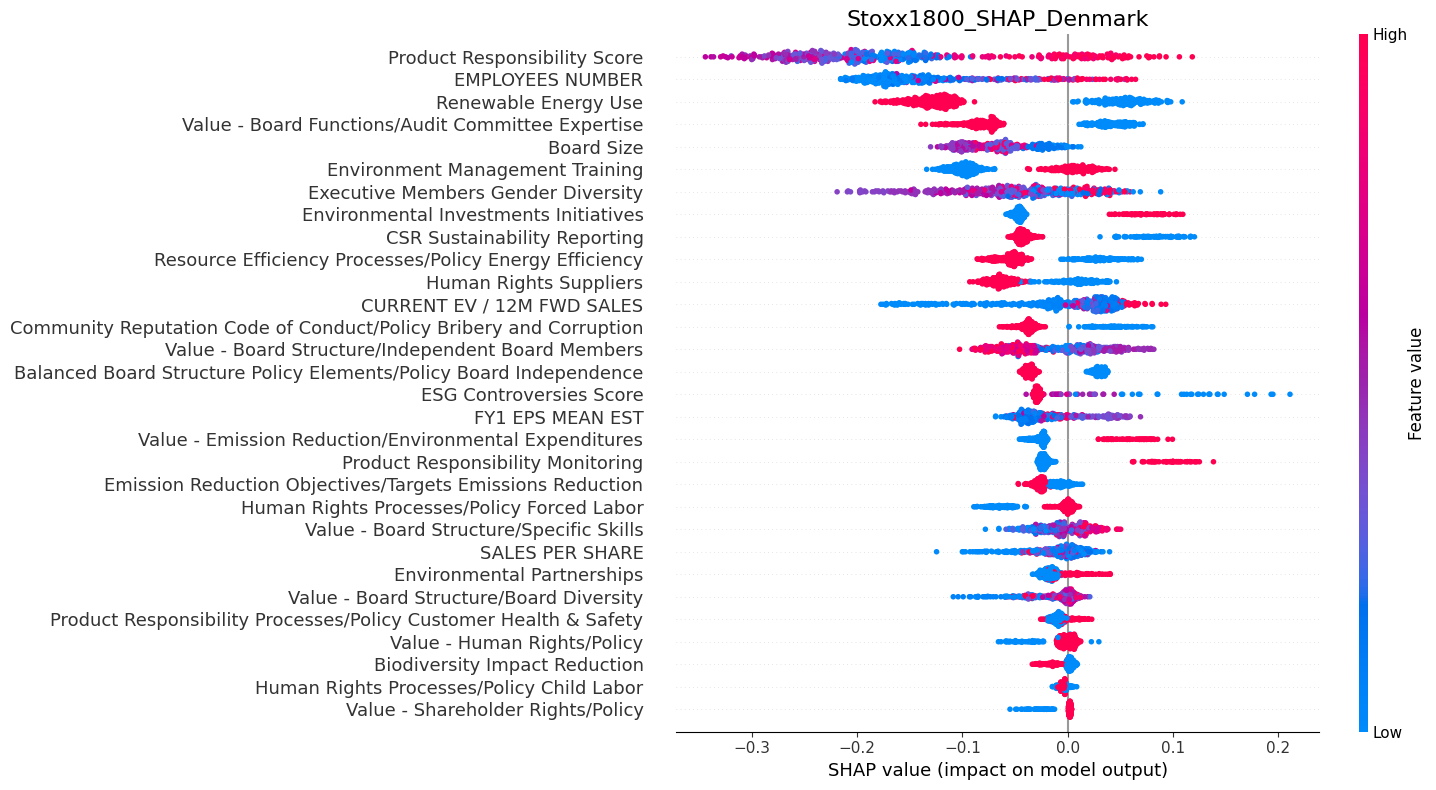

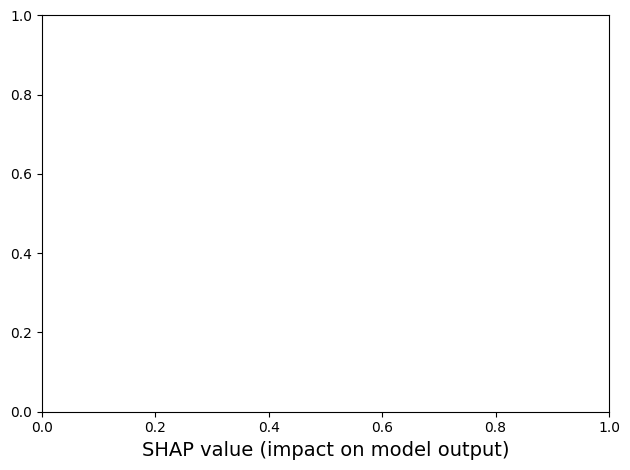

In [17]:
import shap
import matplotlib.pyplot as plt

# 使用 SHAP 解释器计算 SHAP 值
explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)

# 输出 shap_values 的类型和形状
print("SHAP values type:", type(shap_values))
if isinstance(shap_values, list):
    print("SHAP values shape (for each class):", [sv.shape for sv in shap_values])
else:
    print("SHAP values shape:", shap_values.shape)

# 确保 feature_names 被定义
feature_names = X_train.columns

# 绘制总体 SHAP summary plot
# 将 SHAP 值按类别进行平均，得到总体 SHAP 值
shap_values_mean = shap_values.mean(axis=2)

plt.figure(figsize=(15, 8))  # 增大图形尺寸
plt.title("Stoxx1800_SHAP_Denmark", fontsize=16)  # 增大标题字体
shap.summary_plot(shap_values_mean, X_train, feature_names=feature_names, max_display=30, plot_size=(15, 8))
plt.xlabel("SHAP value (impact on model output)", fontsize=14)  # 增大x轴标签字体
plt.tight_layout()  # 自动调整布局
plt.show()  # 显示图形

In [73]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 3, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.7963709677419355 F1 Score: 0.7954567984674619 AUC: 0.9507244330652019 prAUC: 0.8829638766532762
Test Results: Accuracy: 0.78125 F1 Score: 0.7613970588235295 AUC: 0.8909851013133374 prAUC: 0.7083697339902847


In [74]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.2, 'lambda': 2, 'gamma': 3, 'alpha': 1}

Train Results: Accuracy: 0.7721774193548387 F1 Score: 0.7696891994980218 AUC: 0.9361177316582155 prAUC: 0.8474844681858952
Test Results: Accuracy: 0.75 F1 Score: 0.7460137085137084 AUC: 0.8662707427712724 prAUC: 0.6773522511542222


In [75]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8157368967662603, 'gamma': 1, 'learning_rate': 0.07104397735033667, 'max_depth': 13, 'min_child_weight': 7, 'n_estimators': 389, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.6139675812709708}

Train Results: Accuracy: 0.8729838709677419 F1 Score: 0.8722654910157102 AUC: 0.9788238118735503 prAUC: 0.9468764536677058
Test Results: Accuracy: 0.765625 F1 Score: 0.7447777406417111 AUC: 0.8818793682337717 prAUC: 0.6743037343605344


## 1.5 预测冰岛

In [100]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Sweden','Finland','Norway','Denmark'])]
test_data = data[data['Market'] == 'Iceland']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Sweden     322
 Norway      93
 Finland     73
 Denmark     64
 Name: count, dtype: int64,
 Market
 Iceland    8
 Name: count, dtype: int64)

In [101]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


In [103]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    #auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    #pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, 

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


IndexError: tuple index out of range

# 2. 西欧

## 2.1 预测英国

In [104]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Ireland','Netherlands','Belgium','France'])]
test_data = data[data['Market'] == 'United Kingdom']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 France         196
 Netherlands     58
 Belgium         49
 Ireland         14
 Name: count, dtype: int64,
 Market
 United Kingdom    648
 Name: count, dtype: int64)

In [105]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [106]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7949526813880127 F1 Score: 0.7926822521187558 AUC: 0.9513030839434049 prAUC: 0.8784555566574688
Test Results: Accuracy: 0.5879629629629629 F1 Score: 0.5660251132644938 AUC: 0.8395670340281658 prAUC: 0.6176417549814082


In [94]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=18,                # 降低树的深度
    n_estimators=800,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8990536277602523 F1 Score: 0.8984980593401934 AUC: 0.9847401027528686 prAUC: 0.9591153337166471
Test Results: Accuracy: 0.5833333333333334 F1 Score: 0.5709068553057732 AUC: 0.8328590854207958 prAUC: 0.6024705870727934


In [82]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.8233438485804416 F1 Score: 0.8209861252458448 AUC: 0.9594655308255883 prAUC: 0.9004447969015685
Test Results: Accuracy: 0.595679012345679 F1 Score: 0.5783048219953819 AUC: 0.8387358122090948 prAUC: 0.6145769910129713


In [83]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 500, 'max_depth': 30, 'learning_rate': 0.01, 'lambda': 2, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.861198738170347 F1 Score: 0.859508025957837 AUC: 0.975754178449818 prAUC: 0.9368457410820388
Test Results: Accuracy: 0.5802469135802469 F1 Score: 0.5572115137974726 AUC: 0.8352755265820146 prAUC: 0.6105528649533609


In [84]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.7693605922825478, 'gamma': 0, 'learning_rate': 0.1093578407670862, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 792, 'reg_alpha': 3, 'reg_lambda': 3, 'subsample': 0.8856351733429728}

Train Results: Accuracy: 0.9936908517350158 F1 Score: 0.9936623611604487 AUC: 0.9996515274150365 prAUC: 0.9973275354593678
Test Results: Accuracy: 0.5740740740740741 F1 Score: 0.5577901636910118 AUC: 0.8224367964150419 prAUC: 0.5963882450807305


## 2.2 爱尔兰

In [107]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Netherlands','Belgium','France','United Kingdom'])]
test_data = data[data['Market'] == 'Ireland']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 United Kingdom    648
 France            196
 Netherlands        58
 Belgium            49
 Name: count, dtype: int64,
 Market
 Ireland    14
 Name: count, dtype: int64)

In [108]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [109]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7886435331230284 F1 Score: 0.7873760780505253 AUC: 0.9494807026977016 prAUC: 0.8723687711691614
Test Results: Accuracy: 0.5 F1 Score: 0.47802197802197804 AUC: 0.7763888888888889 prAUC: 0.7522168803418803


In [122]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=2,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=15,                # 降低树的深度
    n_estimators=600,          # 树的数量
    learning_rate=0.15,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8475289169295478 F1 Score: 0.8468772158212051 AUC: 0.9713115227117741 prAUC: 0.9259891125583111
Test Results: Accuracy: 0.5714285714285714 F1 Score: 0.586865515436944 AUC: 0.7666666666666666 prAUC: 0.7680823805823805


In [111]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.8159831756046267 F1 Score: 0.8154161406120458 AUC: 0.9597235213900123 prAUC: 0.898582896249069
Test Results: Accuracy: 0.5714285714285714 F1 Score: 0.586865515436944 AUC: 0.7666666666666666 prAUC: 0.7583601583601584


In [112]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 300, 'max_depth': 30, 'learning_rate': 0.1, 'lambda': 2, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.8843322818086226 F1 Score: 0.8838907961276231 AUC: 0.9817387167064591 prAUC: 0.951792131540202
Test Results: Accuracy: 0.5714285714285714 F1 Score: 0.586865515436944 AUC: 0.7770833333333333 prAUC: 0.7652219308469308


In [113]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8157368967662603, 'gamma': 1, 'learning_rate': 0.07104397735033667, 'max_depth': 13, 'min_child_weight': 7, 'n_estimators': 389, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.6139675812709708}

Train Results: Accuracy: 0.8675078864353313 F1 Score: 0.867063563940066 AUC: 0.9787865600142646 prAUC: 0.9422712683581851
Test Results: Accuracy: 0.5714285714285714 F1 Score: 0.586865515436944 AUC: 0.7826388888888889 prAUC: 0.7626578282828282


## 2.3 预测比利时

In [123]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Ireland','Netherlands','France','United Kingdom'])]
test_data = data[data['Market'] == 'Belgium']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 United Kingdom    648
 France            196
 Netherlands        58
 Ireland            14
 Name: count, dtype: int64,
 Market
 Belgium    49
 Name: count, dtype: int64)

In [124]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [125]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7827510917030568 F1 Score: 0.7820130499741289 AUC: 0.948826844206631 prAUC: 0.8730314324831149
Test Results: Accuracy: 0.6938775510204082 F1 Score: 0.6770562770562771 AUC: 0.8261069836973219 prAUC: 0.630102606082135


In [132]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=3,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =2,                   # 添加 gamma 限制分裂
    max_depth=30,                # 降低树的深度
    n_estimators=1000,          # 树的数量
    learning_rate=0.02,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.6,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7358078602620087 F1 Score: 0.733887621680493 AUC: 0.9287809610599758 prAUC: 0.8237102798575686
Test Results: Accuracy: 0.7142857142857143 F1 Score: 0.693500427889706 AUC: 0.8053076378580462 prAUC: 0.6226590837464268


In [127]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 3, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.7849344978165939 F1 Score: 0.7840939011653084 AUC: 0.9490423805419839 prAUC: 0.8709759538317081
Test Results: Accuracy: 0.6938775510204082 F1 Score: 0.676914921812881 AUC: 0.8106424869345726 prAUC: 0.6237962282002607


In [128]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1000, 'max_depth': 30, 'learning_rate': 0.05, 'lambda': 1, 'gamma': 2, 'alpha': 3}

Train Results: Accuracy: 0.7532751091703057 F1 Score: 0.7516630724248501 AUC: 0.9345819851161502 prAUC: 0.836524004299072
Test Results: Accuracy: 0.6938775510204082 F1 Score: 0.676914921812881 AUC: 0.8117368529136872 prAUC: 0.6073058764004201


In [129]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.9887128330883843, 'gamma': 3, 'learning_rate': 0.1334380314193006, 'max_depth': 11, 'min_child_weight': 2, 'n_estimators': 586, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 0.6424202471887338}

Train Results: Accuracy: 0.7347161572052402 F1 Score: 0.7335105686881322 AUC: 0.9316302671017936 prAUC: 0.8297104078670741
Test Results: Accuracy: 0.6938775510204082 F1 Score: 0.6904320169626292 AUC: 0.8151595340428766 prAUC: 0.6331518311591473


## 2.4 预测荷兰

In [5]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Ireland','Belgium','France','United Kingdom'])]
test_data = data[data['Market'] == 'Netherlands']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 United Kingdom    648
 France            196
 Belgium            49
 Ireland            14
 Name: count, dtype: int64,
 Market
 Netherlands    58
 Name: count, dtype: int64)

In [6]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [146]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型

# 使用 XGBoost 模型并设置参数
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               
    reg_lambda=2,              
    gamma=2,                   
    max_depth=4,               
    n_estimators=300,          
    learning_rate=0.1,         
    subsample=0.6,             
    colsample_bytree=0.8,      
    objective='multi:softprob',
    random_state=42
)

# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义评估模型的函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)

    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    
    # 确保在多个类别时计算 AUC 和 prAUC
    if len(set(y)) > 1 and y_binarized.shape[1] > 1 and len(set(y_binarized.flatten())) > 1:
        auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
        pr_auc = average_precision_score(y_binarized, y_pred_proba)
    else:
        auc = "Not Applicable"
        pr_auc = "Not Applicable"

    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [147]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型

# 使用 XGBoost 模型并设置参数
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               
    reg_lambda=2,              
    gamma=2,                   
    max_depth=4,               
    n_estimators=300,          
    learning_rate=0.1,         
    subsample=0.6,             
    colsample_bytree=0.8,      
    objective='multi:softprob',
    random_state=42
)

# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义评估模型的函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)

    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    

    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


Train Results: Accuracy: 0.7816979051819184 F1 Score: 0.7804446615477703
Test Results: Accuracy: 0.7241379310344828 F1 Score: 0.6990785983526456


In [149]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
   
    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])



Train Results: Accuracy: 0.906284454244763 F1 Score: 0.9060939016663053
Test Results: Accuracy: 0.7068965517241379 F1 Score: 0.6838216230230749


In [150]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.8059536934950385 F1 Score: 0.8050062291144647
Test Results: Accuracy: 0.7068965517241379 F1 Score: 0.6777417682136374


In [151]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 300, 'max_depth': 30, 'learning_rate': 0.1, 'lambda': 2, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.8809261300992283 F1 Score: 0.8805023429583513
Test Results: Accuracy: 0.7241379310344828 F1 Score: 0.6990785983526456


## 2.5 预测法国

In [157]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Ireland','Belgium','United Kingdom','Netherlands'])]
test_data = data[data['Market'] == 'France']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 United Kingdom    648
 Netherlands        58
 Belgium            49
 Ireland            14
 Name: count, dtype: int64,
 Market
 France    196
 Name: count, dtype: int64)

In [158]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [159]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7789336801040312 F1 Score: 0.7756345510611057 AUC: 0.9470582378153655 prAUC: 0.8609657946963422
Test Results: Accuracy: 0.5816326530612245 F1 Score: 0.5580903759250043 AUC: 0.8660173058050907 prAUC: 0.6529450383093388


In [161]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9050715214564369 F1 Score: 0.9041858502643222 AUC: 0.9852302317840451 prAUC: 0.9589414573853754
Test Results: Accuracy: 0.5867346938775511 F1 Score: 0.5713898533709689 AUC: 0.86988695014045 prAUC: 0.6642602962793278


In [162]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 2, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.7802340702210663 F1 Score: 0.7765878597955593 AUC: 0.9420634656763879 prAUC: 0.8488409639577934
Test Results: Accuracy: 0.5867346938775511 F1 Score: 0.5650151836117318 AUC: 0.8650620638782962 prAUC: 0.6464011454835379


In [163]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 300, 'max_depth': 30, 'learning_rate': 0.1, 'lambda': 2, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.8777633289986996 F1 Score: 0.8767324312324338 AUC: 0.9788839731413734 prAUC: 0.9412038490834492
Test Results: Accuracy: 0.5918367346938775 F1 Score: 0.57230102732311 AUC: 0.8724575235474421 prAUC: 0.6648638288951474


# 3. 中欧

## 3.1 Germany

In [170]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Switzerland','Austria','Poland'])]
test_data = data[data['Market'] == 'Germany']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Switzerland    178
 Poland          42
 Austria         32
 Name: count, dtype: int64,
 Market
 Germany    293
 Name: count, dtype: int64)

In [171]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [172]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7817460317460317 F1 Score: 0.7751926956689122 AUC: 0.9567576641001213 prAUC: 0.8862194031582037
Test Results: Accuracy: 0.6177474402730375 F1 Score: 0.6067838932684192 AUC: 0.850962919155011 prAUC: 0.6845514412228276


In [184]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =2,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8293650793650794 F1 Score: 0.8247955478487692 AUC: 0.9655942750226794 prAUC: 0.9056589787373566
Test Results: Accuracy: 0.6313993174061433 F1 Score: 0.6224295356740585 AUC: 0.8504570473735669 prAUC: 0.6843398332675652


In [174]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.7777777777777778 F1 Score: 0.768793765265924 AUC: 0.9603744017521365 prAUC: 0.8939263285277037
Test Results: Accuracy: 0.6245733788395904 F1 Score: 0.6124441131096614 AUC: 0.8564802755581397 prAUC: 0.6851509129331484


In [175]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 500, 'max_depth': 30, 'learning_rate': 0.01, 'lambda': 2, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.8373015873015873 F1 Score: 0.8320680327483048 AUC: 0.9790222696520756 prAUC: 0.9375109591780818
Test Results: Accuracy: 0.6279863481228669 F1 Score: 0.6183577220639684 AUC: 0.8575386453927704 prAUC: 0.6977709112042583


In [176]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8343102325093853, 'gamma': 2, 'learning_rate': 0.41047464734119987, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 579, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.9056020883680015}

Train Results: Accuracy: 0.8174603174603174 F1 Score: 0.8114307987887533 AUC: 0.959838572691378 prAUC: 0.8984116318357871
Test Results: Accuracy: 0.6006825938566553 F1 Score: 0.5854936513783614 AUC: 0.8412071106676068 prAUC: 0.6448917828020269


## 3.2 Switzerland

In [186]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Austria','Poland','Germany'])]
test_data = data[data['Market'] == 'Switzerland']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Germany    293
 Poland      42
 Austria     32
 Name: count, dtype: int64,
 Market
 Switzerland    178
 Name: count, dtype: int64)

In [187]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [188]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.779291553133515 F1 Score: 0.7777714675833903 AUC: 0.9414072887314161 prAUC: 0.8614193481325662
Test Results: Accuracy: 0.6460674157303371 F1 Score: 0.6365422489678934 AUC: 0.8729189135227815 prAUC: 0.693619801064982


In [189]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8637602179836512 F1 Score: 0.8628541652157146 AUC: 0.9811348870649338 prAUC: 0.9513385754122998
Test Results: Accuracy: 0.6741573033707865 F1 Score: 0.6690845421639667 AUC: 0.8693371858183899 prAUC: 0.6771677384938557


In [190]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.8065395095367848 F1 Score: 0.8061630556147735 AUC: 0.9534028722603555 prAUC: 0.8901880926360871
Test Results: Accuracy: 0.6460674157303371 F1 Score: 0.6370009627993386 AUC: 0.872069173805679 prAUC: 0.6907569554204324


In [191]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1500, 'max_depth': 20, 'learning_rate': 0.05, 'lambda': 1, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.8719346049046321 F1 Score: 0.8710318665149258 AUC: 0.9829746307696411 prAUC: 0.9553537862989069
Test Results: Accuracy: 0.6629213483146067 F1 Score: 0.6545724284162512 AUC: 0.8744698612015911 prAUC: 0.6856638245815823


In [192]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.7693605922825478, 'gamma': 0, 'learning_rate': 0.1093578407670862, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 792, 'reg_alpha': 3, 'reg_lambda': 3, 'subsample': 0.8856351733429728}

Train Results: Accuracy: 0.989100817438692 F1 Score: 0.9890595452722518 AUC: 0.9997456524176189 prAUC: 0.9988501219918274
Test Results: Accuracy: 0.6685393258426966 F1 Score: 0.6639656974122614 AUC: 0.8643992459586342 prAUC: 0.6845518079000109


## 3.3 Austria

In [193]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Switzerland','Poland','Germany'])]
test_data = data[data['Market'] == 'Austria']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Germany        293
 Switzerland    178
 Poland          42
 Name: count, dtype: int64,
 Market
 Austria    32
 Name: count, dtype: int64)

In [194]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [196]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
   
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])



Train Results: Accuracy: 0.7894736842105263 F1 Score: 0.7891273631329677
Test Results: Accuracy: 0.6875 F1 Score: 0.7020833333333334


In [197]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    
    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:")
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:")




Train Results: Accuracy: 0.9025341130604289 F1 Score: 0.9024969092280906 AUC:
Test Results: Accuracy: 0.6875 F1 Score: 0.7027777777777778 AUC:


In [198]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 3, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.783625730994152 F1 Score: 0.7835317997584831
Test Results: Accuracy: 0.65625 F1 Score: 0.6801020408163265


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

#best 参数
# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.1, 'lambda': 3, 'gamma': 1, 'alpha': 2}

Train Results: Accuracy: 0.8226120857699805 F1 Score: 0.8226272525710441
Test Results: Accuracy: 0.6875 F1 Score: 0.7027777777777778


In [200]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8753999603061465, 'gamma': 0, 'learning_rate': 0.09664716003542288, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 295, 'reg_alpha': 6, 'reg_lambda': 6, 'subsample': 0.8572979613500311}

Train Results: Accuracy: 0.8791423001949318 F1 Score: 0.8788187249314842
Test Results: Accuracy: 0.6875 F1 Score: 0.7027777777777778


## 3.4 Poland

In [16]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Switzerland','Austria','Germany'])]
test_data = data[data['Market'] == 'Poland']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Germany        293
 Switzerland    178
 Austria         32
 Name: count, dtype: int64,
 Market
 Poland    42
 Name: count, dtype: int64)

In [17]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [18]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7992047713717694 F1 Score: 0.7982490328295356 AUC: 0.9453664924617416 prAUC: 0.8594211888745653
Test Results: Accuracy: 0.5476190476190477 F1 Score: 0.5249679581977719 AUC: 0.8132326437660085 prAUC: 0.7029595417659932


In [205]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8866799204771372 F1 Score: 0.8861783193172325 AUC: 0.9841015952835377 prAUC: 0.956154139248651
Test Results: Accuracy: 0.5952380952380952 F1 Score: 0.5733465608465609 AUC: 0.8521248031938822 prAUC: 0.7303861787843482


In [206]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 2, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.7833001988071571 F1 Score: 0.7821141662819161 AUC: 0.9361765608567667 prAUC: 0.8362895063529059
Test Results: Accuracy: 0.5476190476190477 F1 Score: 0.540652833756282 AUC: 0.8083690080283126 prAUC: 0.7002667426381748


In [207]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1200, 'max_depth': 25, 'learning_rate': 0.2, 'lambda': 2, 'gamma': 2, 'alpha': 2}

Train Results: Accuracy: 0.7892644135188867 F1 Score: 0.7885889372649174 AUC: 0.9361162193049304 prAUC: 0.8359829101954085
Test Results: Accuracy: 0.5476190476190477 F1 Score: 0.5249679581977719 AUC: 0.8238820494459592 prAUC: 0.7052431065148393


In [19]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8157368967662603, 'gamma': 1, 'learning_rate': 0.07104397735033667, 'max_depth': 13, 'min_child_weight': 7, 'n_estimators': 389, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.6139675812709708}

Train Results: Accuracy: 0.8489065606361829 F1 Score: 0.8485220500013956 AUC: 0.9720955244256071 prAUC: 0.9211982363139642
Test Results: Accuracy: 0.6190476190476191 F1 Score: 0.6138528138528139 AUC: 0.8256582533485729 prAUC: 0.7009825621870478


In [23]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=13,                # 降低树的深度
    n_estimators=390,          # 树的数量
    learning_rate=0.07,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.82,      # 特征采样率
    objective='multi:softprob',
    random_state=42,
    min_child_weight=7
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8409542743538767 F1 Score: 0.8399174298526008 AUC: 0.9692612416539851 prAUC: 0.913419230183815
Test Results: Accuracy: 0.5952380952380952 F1 Score: 0.5843276774311257 AUC: 0.8400812585493036 prAUC: 0.7148043142844496


# 4. 南欧及地中海地区

## 4.1 Italy

In [228]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Spain','Portugal','Greece','Turkey','Hungary'])]
test_data = data[data['Market'] == 'Italy']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Turkey      117
 Spain        72
 Greece       25
 Portugal     16
 Hungary       7
 Name: count, dtype: int64,
 Market
 Italy    128
 Name: count, dtype: int64)

In [210]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [211]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8227848101265823 F1 Score: 0.813155307083752 AUC: 0.9584679716584945 prAUC: 0.9036810764088579
Test Results: Accuracy: 0.5859375 F1 Score: 0.5081773768886773 AUC: 0.8204378434325107 prAUC: 0.6051806550038983


In [227]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=30,                # 降低树的深度
    n_estimators=1600,          # 树的数量
    learning_rate=0.2,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9240506329113924 F1 Score: 0.9222029854549748 AUC: 0.990948294528337 prAUC: 0.9730435014440614
Test Results: Accuracy: 0.65625 F1 Score: 0.611167278812022 AUC: 0.8318287912456761 prAUC: 0.6235373403229251


In [213]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.8481012658227848 F1 Score: 0.8412086589301778 AUC: 0.9663327317637627 prAUC: 0.9154116716938789
Test Results: Accuracy: 0.59375 F1 Score: 0.5264953997902178 AUC: 0.821300567205588 prAUC: 0.5911794158260415


In [214]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1200, 'max_depth': 20, 'learning_rate': 0.2, 'lambda': 1, 'gamma': 1, 'alpha': 2}

Train Results: Accuracy: 0.8734177215189873 F1 Score: 0.8707753286315486 AUC: 0.9787286985866195 prAUC: 0.9381817283888012
Test Results: Accuracy: 0.640625 F1 Score: 0.5896963085728242 AUC: 0.828076924345979 prAUC: 0.6159799611540233


In [215]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8473015537351571, 'gamma': 0, 'learning_rate': 0.3378613176903711, 'max_depth': 14, 'min_child_weight': 2, 'n_estimators': 314, 'reg_alpha': 1, 'reg_lambda': 7, 'subsample': 0.5590824138108281}

Train Results: Accuracy: 1.0 F1 Score: 1.0 AUC: 1.0 prAUC: 1.0
Test Results: Accuracy: 0.6015625 F1 Score: 0.5724461863879556 AUC: 0.8217302477723594 prAUC: 0.6200579996244054


## 4.2 Spain

In [229]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Portugal','Greece','Turkey','Hungary','Italy'])]
test_data = data[data['Market'] == 'Spain']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Italy       128
 Turkey      117
 Greece       25
 Portugal     16
 Hungary       7
 Name: count, dtype: int64,
 Market
 Spain    72
 Name: count, dtype: int64)

In [230]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [232]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')

    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])



Train Results: Accuracy: 0.8430034129692833 F1 Score: 0.8396245693602722
Test Results: Accuracy: 0.625 F1 Score: 0.5880020734389667


In [233]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')

    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:")
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:")



Train Results: Accuracy: 0.9215017064846417 F1 Score: 0.9206170515194488 AUC:
Test Results: Accuracy: 0.6111111111111112 F1 Score: 0.5929977596644264 AUC:


In [234]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.863481228668942 F1 Score: 0.8609602461498901
Test Results: Accuracy: 0.6111111111111112 F1 Score: 0.5769129200501749


In [236]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


Fitting 3 folds for each of 30 candidates, totalling 90 fits


Best Parameters: {'n_estimators': 1500, 'max_depth': 20, 'learning_rate': 0.05, 'lambda': 1, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.9215017064846417 F1 Score: 0.9207540572350215
Test Results: Accuracy: 0.6388888888888888 F1 Score: 0.6169488536155203


In [237]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8473015537351571, 'gamma': 0, 'learning_rate': 0.3378613176903711, 'max_depth': 14, 'min_child_weight': 2, 'n_estimators': 314, 'reg_alpha': 1, 'reg_lambda': 7, 'subsample': 0.5590824138108281}

Train Results: Accuracy: 1.0 F1 Score: 1.0
Test Results: Accuracy: 0.6527777777777778 F1 Score: 0.645923926625681


In [239]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=7,              # L2 正则化
    gamma =0,                   # 添加 gamma 限制分裂
    max_depth=14,                # 降低树的深度
    n_estimators=314,          # 树的数量
    learning_rate=0.3,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42,
    colsmple_bylevel=0.8,

)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')

    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


/Applications/hello/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:22:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "colsmple_bylevel" } are not used.

  warnings.warn(smsg, UserWarning)



Train Results: Accuracy: 1.0 F1 Score: 1.0
Test Results: Accuracy: 0.6666666666666666 F1 Score: 0.667014792677571


## 4.3 Greece

In [3]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Portugal','Turkey','Hungary','Italy','Spain'])]
test_data = data[data['Market'] == 'Greece']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Italy       128
 Turkey      117
 Spain        72
 Portugal     16
 Hungary       7
 Name: count, dtype: int64,
 Market
 Greece    25
 Name: count, dtype: int64)

In [4]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [5]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8264705882352941 F1 Score: 0.8231549414227728 AUC: 0.9575326004876685 prAUC: 0.9015531070572974
Test Results: Accuracy: 0.56 F1 Score: 0.5062857142857143 AUC: 0.8244444444444445 prAUC: 0.6609945025734498


In [6]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9205882352941176 F1 Score: 0.9199838288073582 AUC: 0.9899387069827487 prAUC: 0.9696693068425402
Test Results: Accuracy: 0.64 F1 Score: 0.6201265401265402 AUC: 0.8467460317460318 prAUC: 0.7147175850465324


In [263]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.8411764705882353 F1 Score: 0.8375602730268659 AUC: 0.9610667532748065 prAUC: 0.909456040613407
Test Results: Accuracy: 0.52 F1 Score: 0.47580952380952385 AUC: 0.808531746031746 prAUC: 0.6429635717923533


In [267]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=1,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 300, 'max_depth': 30, 'learning_rate': 0.1, 'lambda': 2, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.8970588235294118 F1 Score: 0.8959106154423493 AUC: 0.9860931082817929 prAUC: 0.9623101332259243
Test Results: Accuracy: 0.56 F1 Score: 0.531047619047619 AUC: 0.826468253968254 prAUC: 0.6537524112208986


In [268]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=1,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=1
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.7059678230651237, 'gamma': 1, 'learning_rate': 0.39212080437721386, 'max_depth': 11, 'min_child_weight': 7, 'n_estimators': 430, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.6301575492892705}

Train Results: Accuracy: 0.9029411764705882 F1 Score: 0.9024475443436646 AUC: 0.9861754957564981 prAUC: 0.946313239779911
Test Results: Accuracy: 0.56 F1 Score: 0.5553939393939394 AUC: 0.8503968253968254 prAUC: 0.6904702935952935


## 4.4 Portugal

In [4]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Spain','Greece','Turkey','Hungary','Italy'])]
test_data = data[data['Market'] == 'Portugal']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Italy      128
 Turkey     117
 Spain       72
 Greece      25
 Hungary      7
 Name: Market, dtype: int64,
 Portugal    16
 Name: Market, dtype: int64)

In [5]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [278]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
   
    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])



Train Results: Accuracy: 0.8051575931232091 F1 Score: 0.8011837678731816
Test Results: Accuracy: 0.875 F1 Score: 0.87


In [279]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    
    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])



Train Results: Accuracy: 0.9197707736389685 F1 Score: 0.9192320466898308
Test Results: Accuracy: 0.8125 F1 Score: 0.8125


In [281]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])

Fitting 3 folds for each of 243 candidates, totalling 729 fits


Best Parameters: {'alpha': 1, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.839541547277937 F1 Score: 0.8368226035490145
Test Results: Accuracy: 0.875 F1 Score: 0.87


In [282]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.839541547277937 F1 Score: 0.8368226035490145
Test Results: Accuracy: 0.875 F1 Score: 0.87


In [6]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=10,               # 降低树的深度
    n_estimators=1000,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
   
    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])



Train Results: Accuracy: 0.839541547277937 F1 Score: 0.8368226035490145
Test Results: Accuracy: 0.875 F1 Score: 0.87


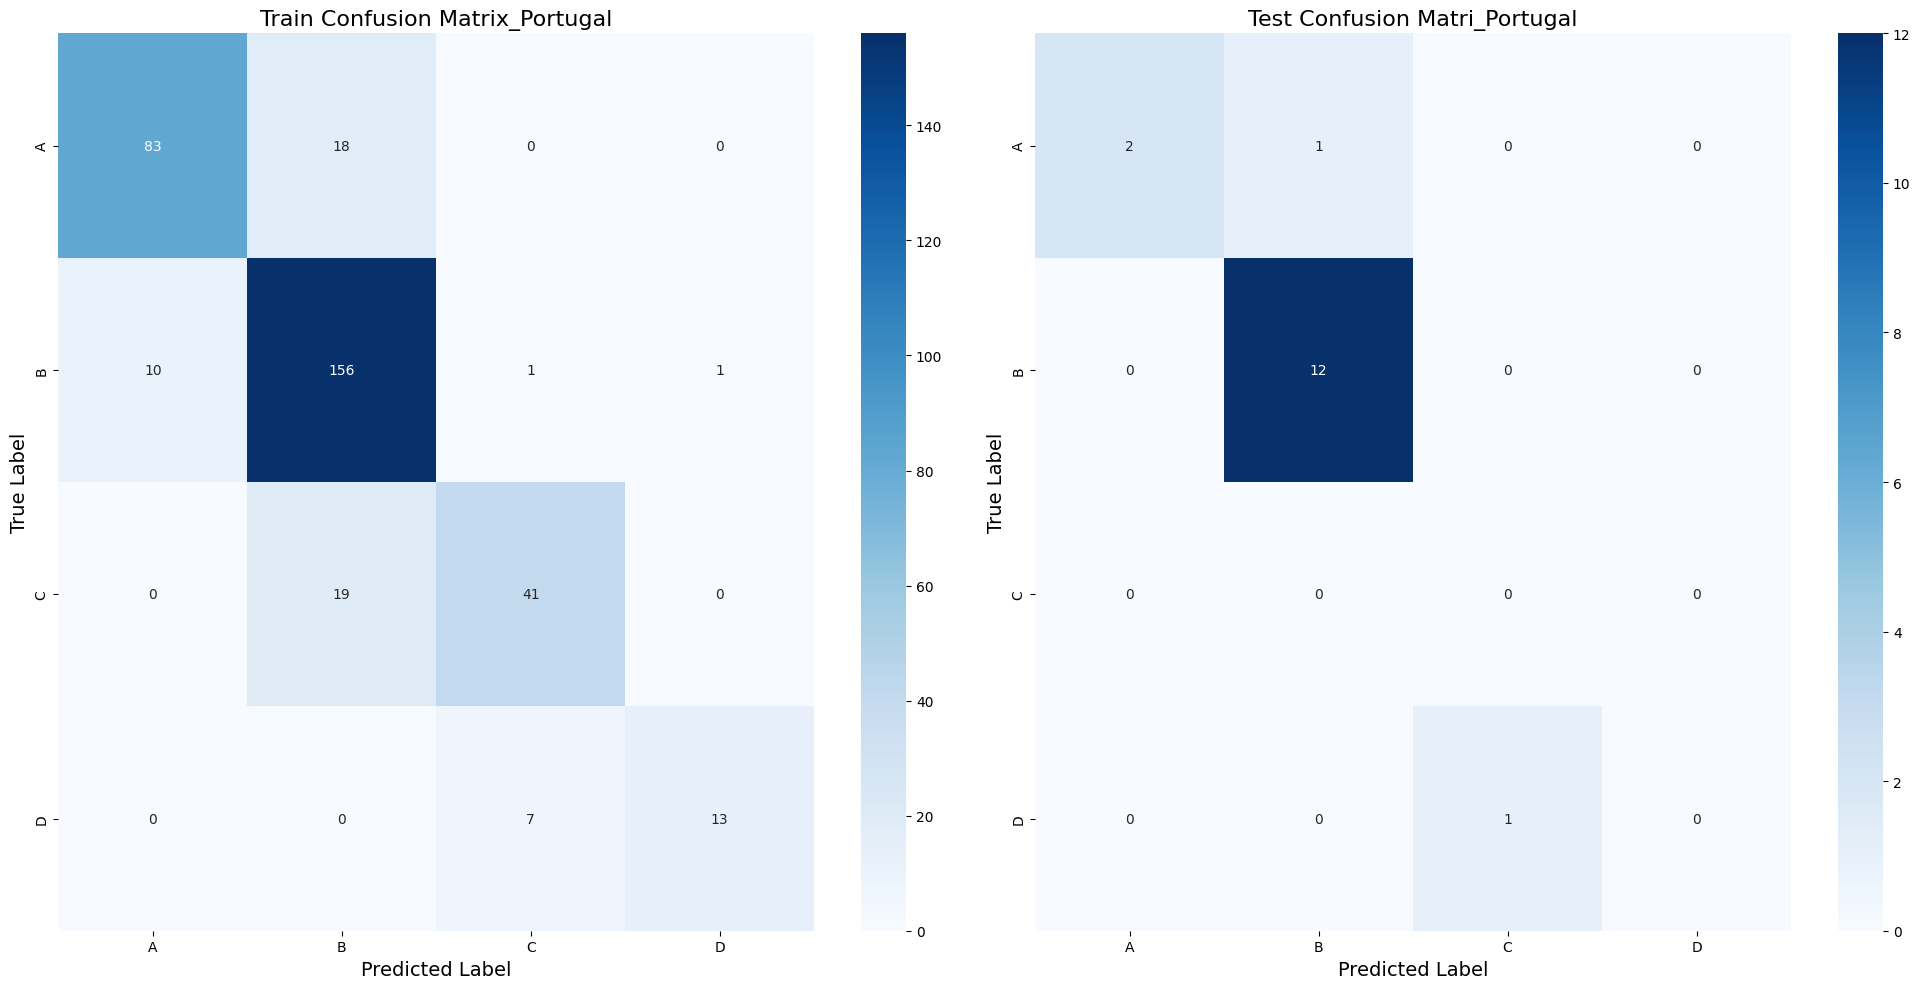

In [7]:
# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# 绘制训练集和测试集的混淆矩阵
y_train_pred = tuned_xgb_model.predict(X_train)
y_test_pred = tuned_xgb_model.predict(X_test)

conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(20, 10))

# 训练集混淆矩阵
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Train Confusion Matrix_Portugal', fontsize=16)

# 测试集混淆矩阵
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Test Confusion Matri_Portugal', fontsize=16)

plt.tight_layout()
plt.show()


SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (349, 41, 4)


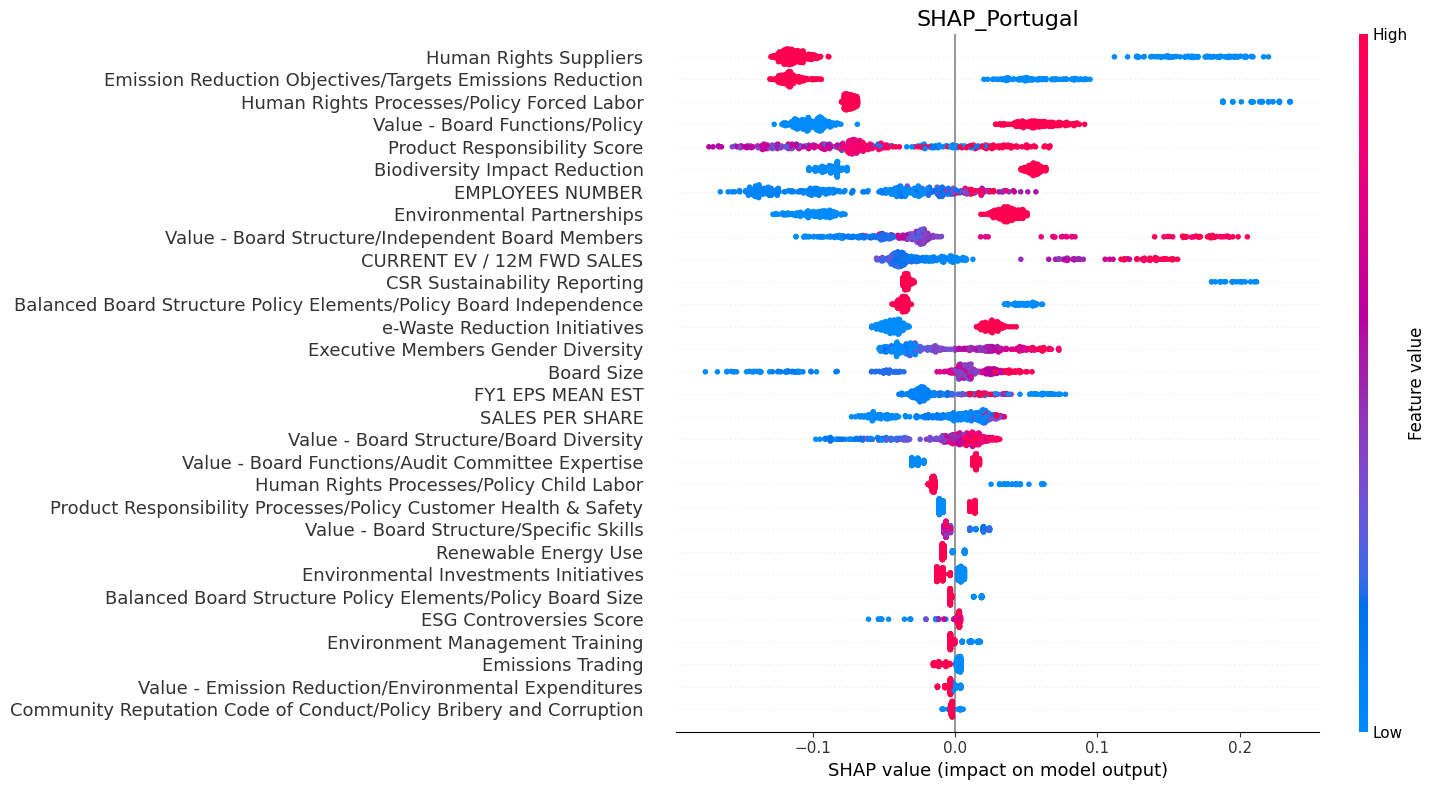

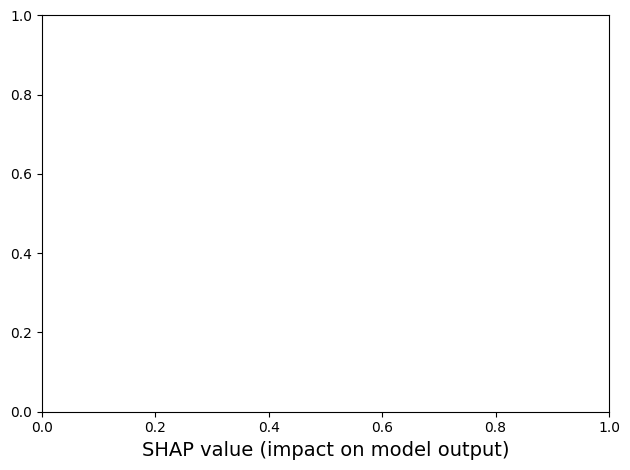

In [8]:
import shap
import matplotlib.pyplot as plt

# 使用 SHAP 解释器计算 SHAP 值
explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)

# 输出 shap_values 的类型和形状
print("SHAP values type:", type(shap_values))
if isinstance(shap_values, list):
    print("SHAP values shape (for each class):", [sv.shape for sv in shap_values])
else:
    print("SHAP values shape:", shap_values.shape)

# 确保 feature_names 被定义
feature_names = X_train.columns

# 绘制总体 SHAP summary plot
# 将 SHAP 值按类别进行平均，得到总体 SHAP 值
shap_values_mean = shap_values.mean(axis=2)

plt.figure(figsize=(15, 8))  # 增大图形尺寸
plt.title("SHAP_Portugal", fontsize=16)  # 增大标题字体
shap.summary_plot(shap_values_mean, X_train, feature_names=feature_names, max_display=30, plot_size=(15, 8))
plt.xlabel("SHAP value (impact on model output)", fontsize=14)  # 增大x轴标签字体
plt.tight_layout()  # 自动调整布局
plt.show()  # 显示图形

In [283]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8343102325093853, 'gamma': 2, 'learning_rate': 0.41047464734119987, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 579, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.9056020883680015}

Train Results: Accuracy: 0.836676217765043 F1 Score: 0.8339278103328622
Test Results: Accuracy: 0.8125 F1 Score: 0.8218167701863354


## 4.5 Turkey

In [9]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Spain','Portugal','Greece','Hungary','Italy'])]
test_data = data[data['Market'] == 'Turkey']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Italy       128
 Spain        72
 Greece       25
 Portugal     16
 Hungary       7
 Name: Market, dtype: int64,
 Turkey    117
 Name: Market, dtype: int64)

In [10]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [286]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8024193548387096 F1 Score: 0.7917692775024604 AUC: 0.9609807897354377 prAUC: 0.9020894078939666
Test Results: Accuracy: 0.4444444444444444 F1 Score: 0.31409638494658737 AUC: 0.8138332594430484 prAUC: 0.6688268752620532


In [14]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9112903225806451 F1 Score: 0.9101446186993588 AUC: 0.9920040607468097 prAUC: 0.9799938000825799
Test Results: Accuracy: 0.46153846153846156 F1 Score: 0.37012538238344694 AUC: 0.8028907921323234 prAUC: 0.6452203002564297


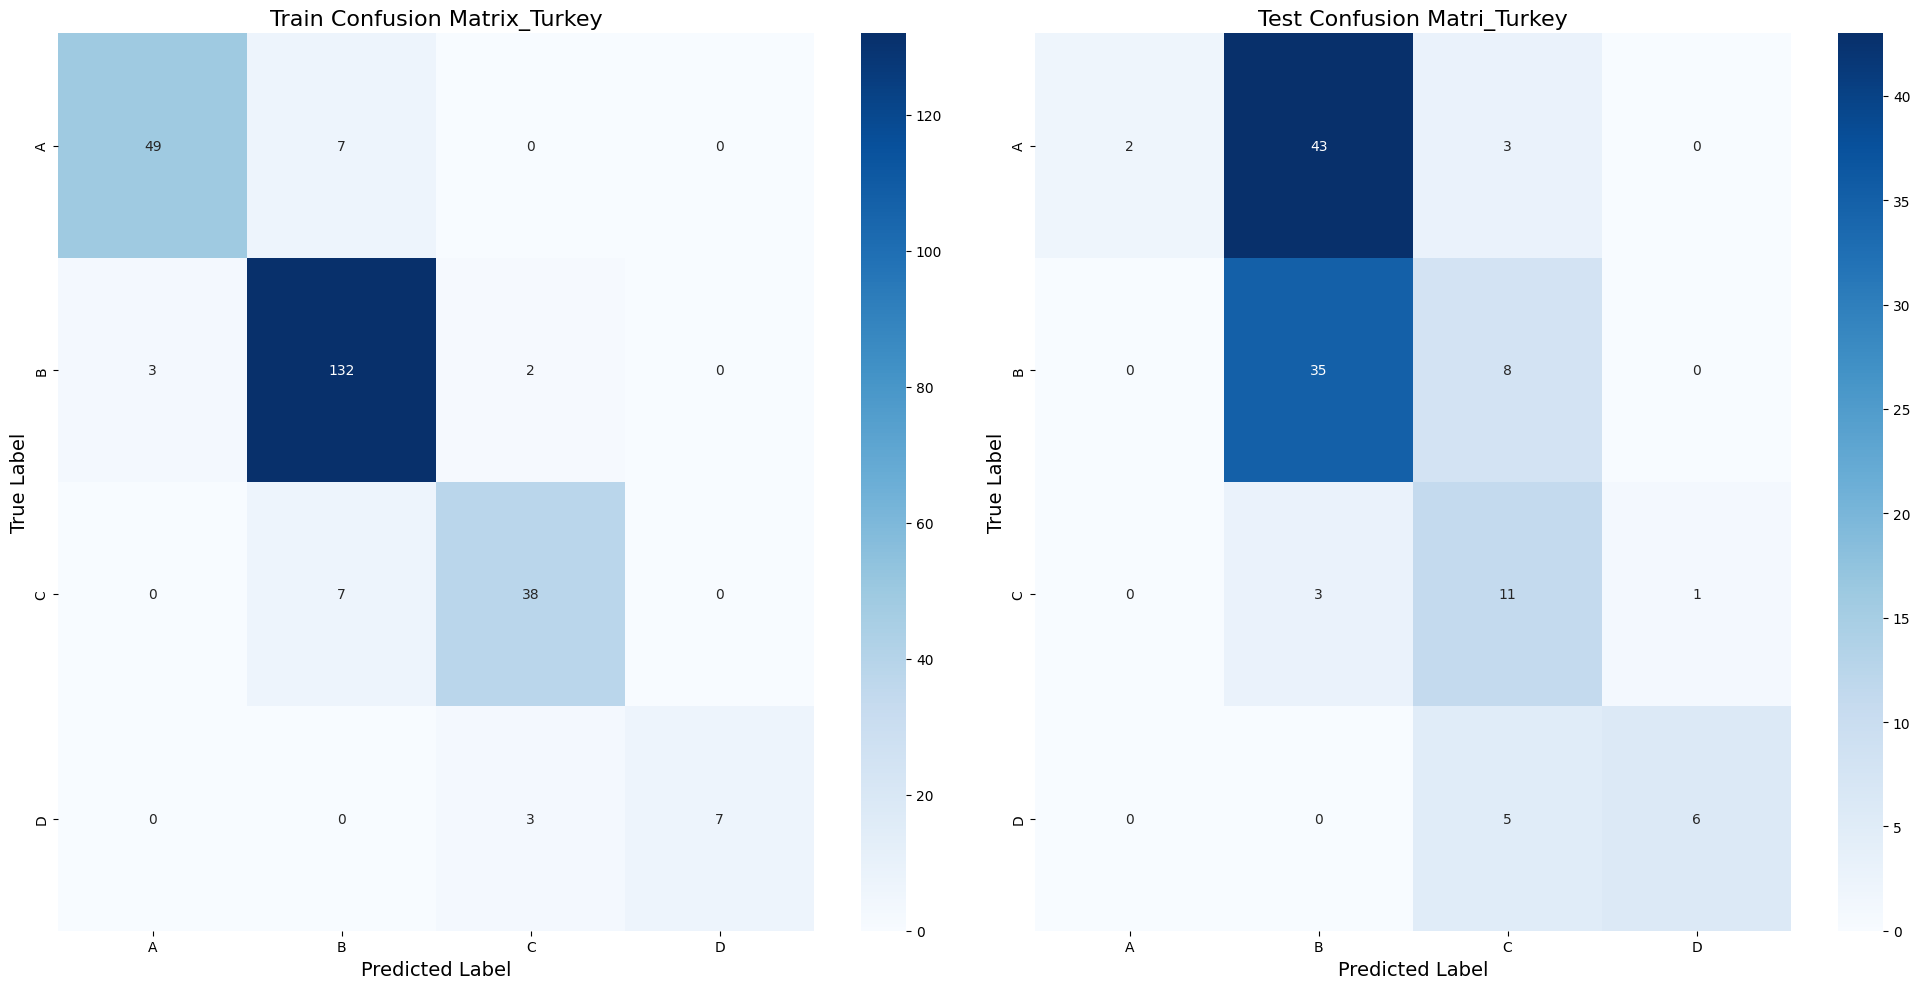

In [15]:
# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# 绘制训练集和测试集的混淆矩阵
y_train_pred = tuned_xgb_model.predict(X_train)
y_test_pred = tuned_xgb_model.predict(X_test)

conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(20, 10))

# 训练集混淆矩阵
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Train Confusion Matrix_Turkey', fontsize=16)

# 测试集混淆矩阵
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Test Confusion Matri_Turkey', fontsize=16)

plt.tight_layout()
plt.show()

SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (248, 41, 4)


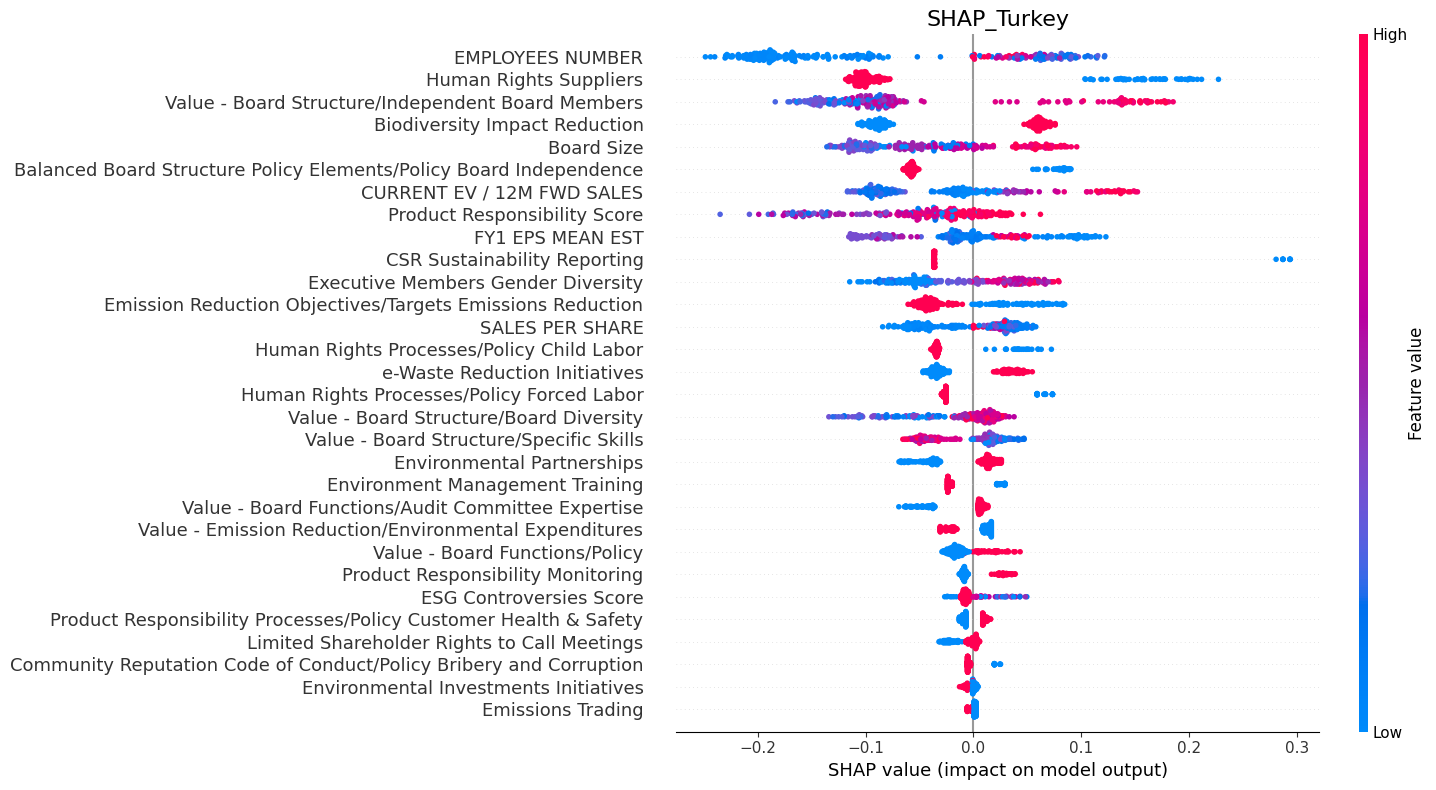

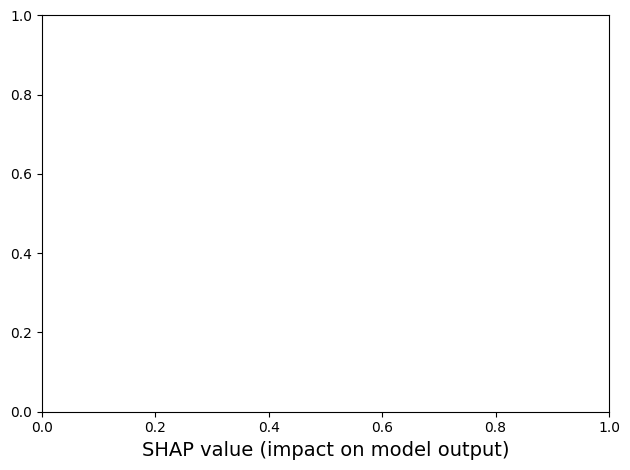

In [16]:
import shap
import matplotlib.pyplot as plt

# 使用 SHAP 解释器计算 SHAP 值
explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)

# 输出 shap_values 的类型和形状
print("SHAP values type:", type(shap_values))
if isinstance(shap_values, list):
    print("SHAP values shape (for each class):", [sv.shape for sv in shap_values])
else:
    print("SHAP values shape:", shap_values.shape)

# 确保 feature_names 被定义
feature_names = X_train.columns

# 绘制总体 SHAP summary plot
# 将 SHAP 值按类别进行平均，得到总体 SHAP 值
shap_values_mean = shap_values.mean(axis=2)

plt.figure(figsize=(15, 8))  # 增大图形尺寸
plt.title("SHAP_Turkey", fontsize=16)  # 增大标题字体
shap.summary_plot(shap_values_mean, X_train, feature_names=feature_names, max_display=30, plot_size=(15, 8))
plt.xlabel("SHAP value (impact on model output)", fontsize=14)  # 增大x轴标签字体
plt.tight_layout()  # 自动调整布局
plt.show()  # 显示图形

In [288]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.842741935483871 F1 Score: 0.837661799188584 AUC: 0.972115614794509 prAUC: 0.9312792238388968
Test Results: Accuracy: 0.4358974358974359 F1 Score: 0.31387442966390333 AUC: 0.8057720816848273 prAUC: 0.6552236255329303
